# Applies Deep Learning to ePodium dataset.

__input dimensions__: 
+ x (batches, timesteps, channels)
+ y (batches, labels)

__labels__: 
+ Binary: Sex, At risk of dyslexia, Group a/b
+ Regressive: Age, Vocabulary

#### Import Packages

In [1]:
import mne
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.metrics import Precision, BinaryAccuracy, Recall
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import local_paths
from functions import epodium, epodium_deep_learning, display_helper

from models import transformer
from models.dnn import fully_connected_model
from models.hfawaz import cnn, encoder

<br>

## Input Preparation


#### Split processed epochs* into train and test sequence.

*In the context of electroencephalography (EEG), *epochs* are EEG segments in which an event occurs. During processing, the epochs are chosen to be 1 second in which the event occurs at 0.2s. In the context of deep learning, *epochs* are iterations over the entire training dataset.

First choose which processed data to use

In [2]:
processing_method = "autoreject"
experiment_list = epodium_deep_learning.clean_experiments(processing_method)
train, test = epodium_deep_learning.split_train_test_datasets(experiment_list)

Analyzed: 228, bad: 42
186 files have enough epochs for analysis.
The dataset is split up into 138 train and 48 test experiments


#### Preparing data iterator (Sequence) as input to the deep learning models.
https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence

In [3]:
train_sequence = epodium_deep_learning.EvokedDataIterator(train, "autoreject_128hz", gaussian_noise = 1e-6)
test_sequence = epodium_deep_learning.EvokedDataIterator(test, "autoreject_128hz")

#### Visualise data instance

The shape of one data instance is (64, 128)


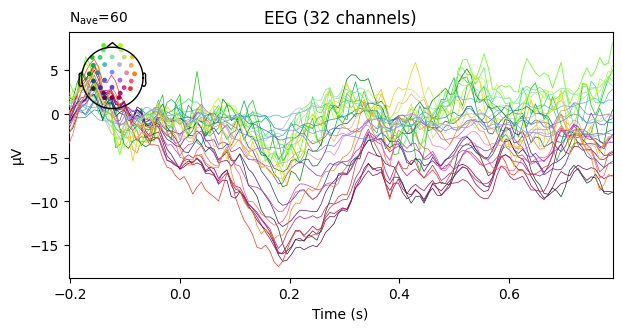

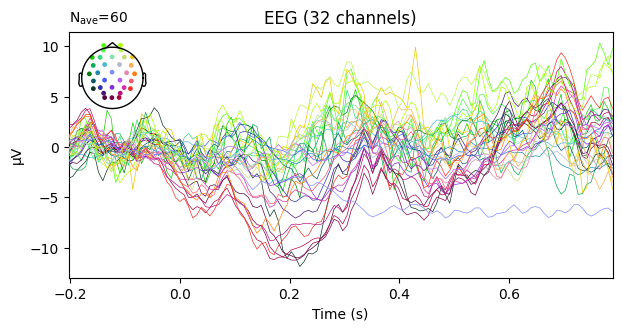

In [4]:
x, y = test_sequence.__getitem__(6)
print(f"The shape of one data instance is {x[0].shape}")

index = 15 # 0 to 63
epodium.plot_array_as_evoked(x[index][:32], frequency = 128)
epodium.plot_array_as_evoked(x[index][32:], frequency = 128)

In [5]:
# TODO SHOW Downsample differences

# TODO Show noise differences

<br>

## Deep Learning

The data is an *evoked* or *ERP* from a participant in the ePodium experiment. 60 EEG signals were averaged from -0.2 to +0.8 seconds after onset of an event. This is done for each of the 12 event types seperately.




#### Train model

In [6]:
model_name = "encoder_age_128_3"
model = encoder((64,128), 1)
epochs = 300
learning_rate = 1e-5

# Paths to save model info
base_path = os.path.join(local_paths.models, model_name)

path_history = os.path.join(base_path, "history.npy")
path_model = os.path.join(base_path, "model")
path_testset = os.path.join(base_path, "testset.txt")
path_weights = os.path.join(base_path, "weights.h5")

if os.path.exists(path_model):
    print(f"Model: '{model_name}' already exist. Delete the existing model first or rename this model.")    
else:
    print(f"Create model: {model_name}")
    if not os.path.exists(base_path):
        os.mkdir(base_path)

    # Save validation-set for future testing
    with open(path_testset, 'w') as f:
        for participant in test:
            f.write(participant + '\n')

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError()) # , metrics=[Precision(), BinaryAccuracy(), Recall()]

    # Fit model
    checkpointer = ModelCheckpoint(filepath = path_weights, monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.7, verbose=1) # add to callbacks if uncomment
    history = model.fit(x=train_sequence, validation_data=test_sequence, epochs=epochs, callbacks=[checkpointer])

    np.save(path_history, history.history)
    model.save(path_model)

2022-09-15 20:43:19.711451: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 20:43:19.753314: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 20:43:19.753541: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 20:43:19.758012: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Create model: encoder_age_128_3
Epoch 1/300


2022-09-15 20:43:31.186212: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-09-15 20:43:31.809816: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


18/18 [==============================] - ETA: 0s - loss: 0.2573
Epoch 1: val_loss improved from inf to 0.25072, saving model to /volume-ceph/floris_storage/models/encoder_age_128_3/weights.h5
18/18 [==============================] - 128s 7s/step - loss: 0.2573 - val_loss: 0.2507
Epoch 2/300
18/18 [==============================] - ETA: 0s - loss: 0.2557
Epoch 2: val_loss improved from 0.25072 to 0.24966, saving model to /volume-ceph/floris_storage/models/encoder_age_128_3/weights.h5
18/18 [==============================] - 44s 2s/step - loss: 0.2557 - val_loss: 0.2497
Epoch 3/300
18/18 [==============================] - ETA: 0s - loss: 0.2547
Epoch 3: val_loss improved from 0.24966 to 0.24808, saving model to /volume-ceph/floris_storage/models/encoder_age_128_3/weights.h5
18/18 [==============================] - 43s 2s/step - loss: 0.2547 - val_loss: 0.2481
Epoch 4/300
18/18 [==============================] - ETA: 0s - loss: 0.2531
Epoch 4: val_loss improved from 0.24808 to 0.24685, sa

INFO:tensorflow:Assets written to: /volume-ceph/floris_storage/models/encoder_age_128_3/model/assets


INFO:tensorflow:Assets written to: /volume-ceph/floris_storage/models/encoder_age_128_3/model/assets


#### Show Training History

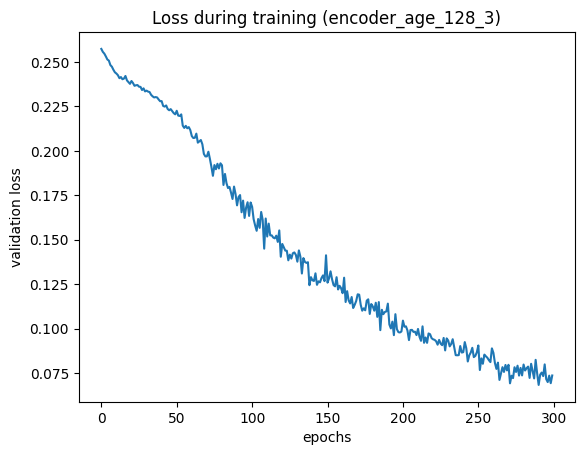

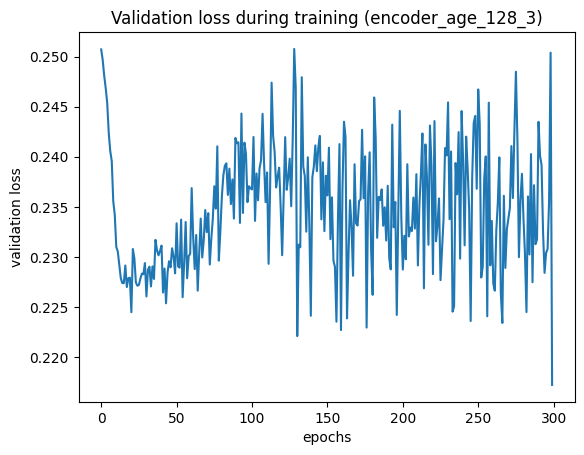

In [7]:
display_helper.show_plot(x = range(len(history.history['loss'])), y = history.history['loss'], xlabel = "epochs", ylabel = "validation loss", title = f"Loss during training ({model_name})")
display_helper.show_plot(x = range(len(history.history['loss'])), y = history.history['val_loss'], xlabel = "epochs", ylabel = "validation loss", title = f"Validation loss during training ({model_name})")